# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [56]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything

# Plotting style
%matplotlib ipympl

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

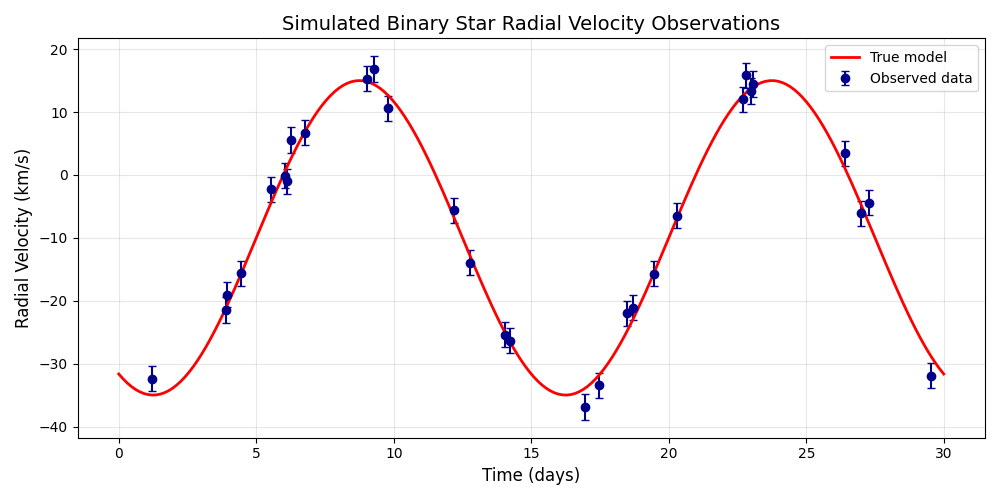

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [83]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [76]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    # you're doing this
    v_model = radial_velocity_model(t,theta[0],theta[1],theta[2],theta[3])
    chi_squared = np.sum(((v- v_model) / v_err)**2)
    return -chi_squared / 2 + np.sum(-np.log(v_err*np.sqrt(2 * np.pi)))

def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    # you're doing this
    if (20 < theta[0] < 30 and 10 < theta[1] < 20 and 3 < theta[2] < 7 and -15 < theta[3] < -5):
        return -np.log((10*10*4*10))
    else:
        return -np.inf
    
def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    # you're doing this
    return log_likelihood(theta, t, v, v_err) + log_prior(theta)

#### Justify the choice of prior in a few sentences

The reason I chose these priors is because I looked at the simulated observations and came up with a range of values I thought
could match the model given the equation of the model too.
#### Describe how you treated the uncertainties in a few sentences

I plugged v_err into the equation where it belongs. I don't know how else to explain this.

#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [77]:
# MCMC setup
ndim = 4
nwalkers = 500
nsteps = 1000

# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.
guess = [22,12,4,-13]
sigmas = np.ones(4)
starting_point = np.array(guess) + 0.1*sigmas*np.random.randn(nwalkers, ndim)


#### Run the MCMC Sampler
This may take a minute or two.

In [78]:
# Initialize the sampler
kwargs = {'t' : t_obs, 'v': v_obs, 'v_err': v_err}

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, kwargs=kwargs )

# Run MCMC
state = sampler.run_mcmc(starting_point, 1000)
sampler.reset()
sampler.run_mcmc(state, 10000, progress=True)
# Print the acceptance fraction from the sampler
print(np.mean(sampler.acceptance_fraction))


You must install the tqdm library to use progress indicators with emcee


0.5940692000000001


#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

Burnin: 89
Thin: 22
Autocorrelation times: [44.87656356 44.55723711 44.42450217 44.66509898]


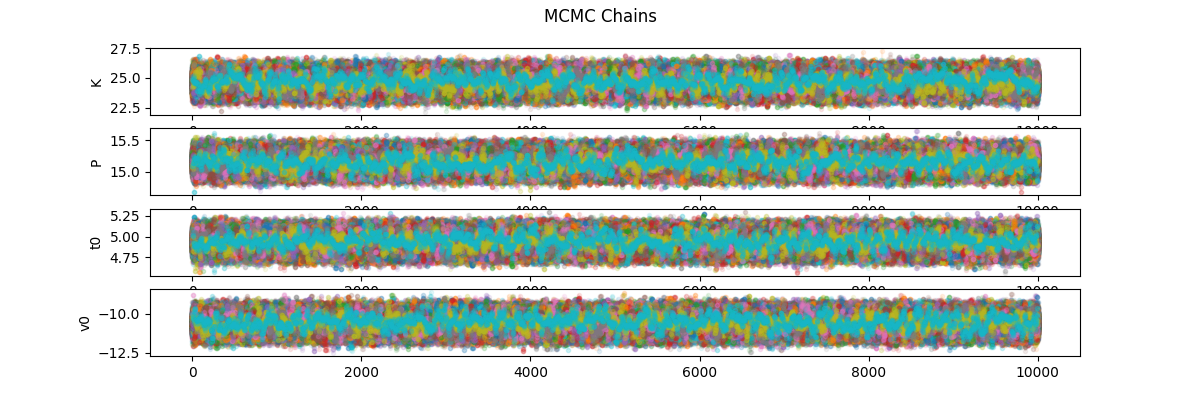

In [ ]:
# Plot the chains - and remember to label your plots - you aren't silly first-years
samples = sampler.get_chain()
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 4))
labels=['K', 'P', 't0', 'v0']

fig.suptitle('MCMC Chains')

for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:,:,i], linestyle='-', marker='.', alpha=0.1)
    ax.set_ylabel(labels[i])
        
# Calculate autocorrelation time
auto_time = sampler.get_autocorr_time()
burnin = int(2 * np.max(auto_time))
thin = int(0.5 * np.min(auto_time))
print('Burnin:', burnin)
print('Thin:', thin)


In [ ]:
print('Autocorrelation times:', auto_time)

#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [ ]:
# Get flattened samples (discard burn-in and thin)
flattened_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
# Calculate parameter estimates
for i, label in enumerate(labels):
    percentile = np.percentile(flattened_samples[:, i], [16, 50, 84])
    diff = np.diff(percentile)
    print(label, ':', percentile[1], 'Upper Error:', diff[1], 'Lower Error:', -diff[0])

K : 24.646671240693834 Upper Error: 0.5157260536360333 Lower Error: -0.5150539530021412
P : 15.155738599297559 Upper Error: 0.09797855776677622 Lower Error: -0.09666398050469915
t0 : 4.945561263302352 Upper Error: 0.07518965927975518 Lower Error: -0.07651627510456649
v0 : -10.568620372716381 Upper Error: 0.39683189424608756 Lower Error: -0.3976534667110787


#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

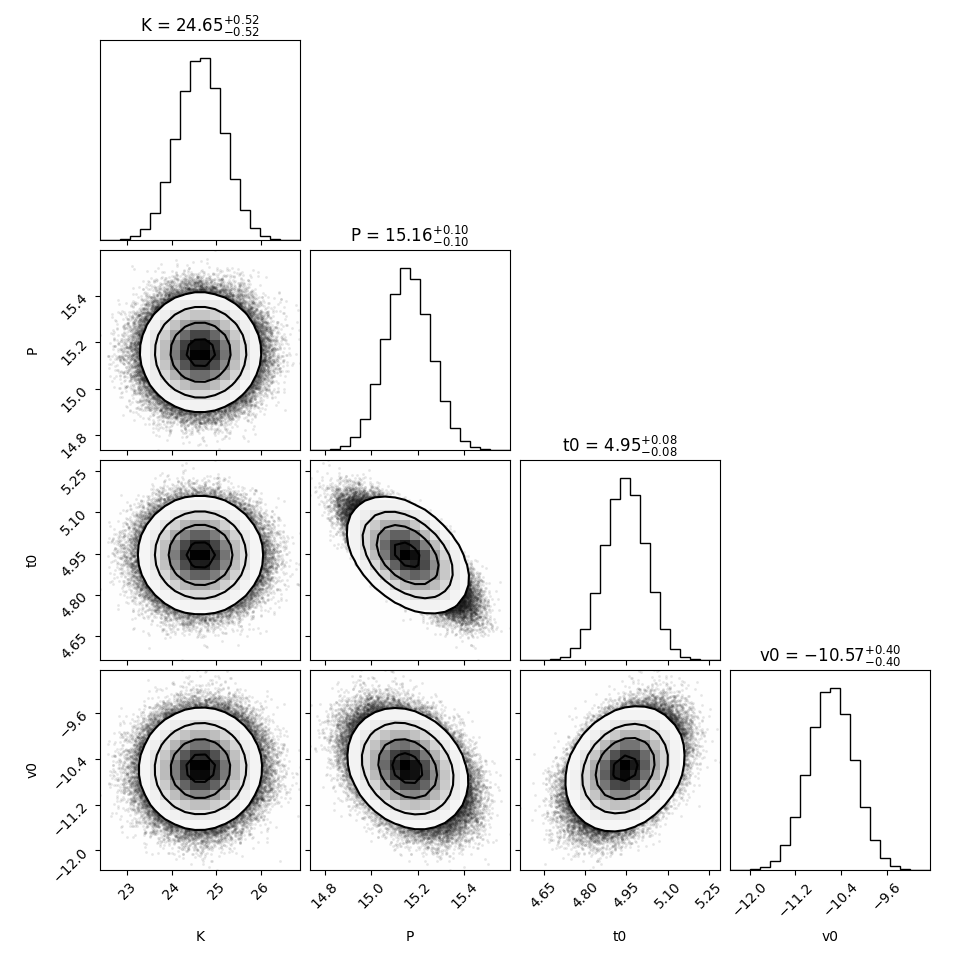

In [81]:
# you can use the corner package 
fig = corner.corner(flattened_samples, plot_contours=True, show_titles=True, smooth=2, labels=labels)

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

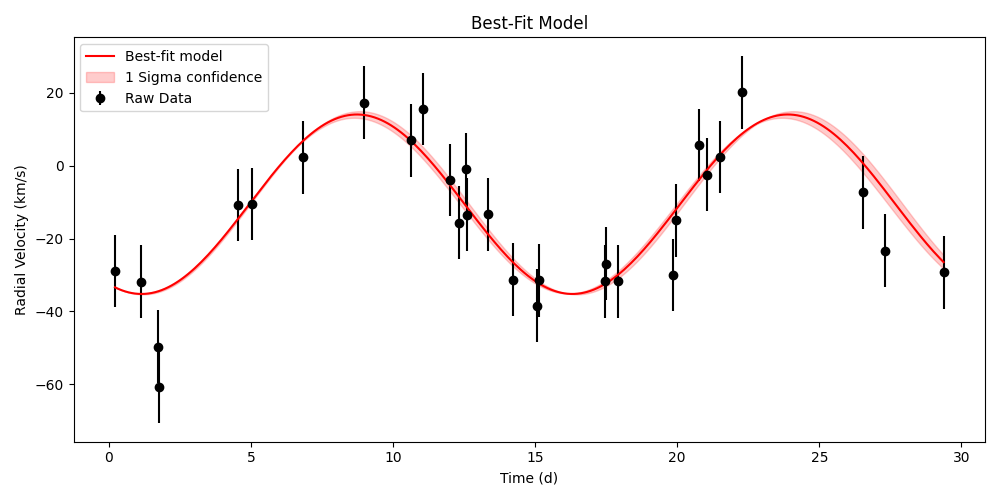

In [107]:
# also plot the true model - you can look at the simulation code
time = np.linspace(min(t_obs), max(t_obs), 250)

mean = np.mean(flattened_samples, axis = 0)
lower = np.percentile(flattened_samples, 16, axis=0)
upper = np.percentile(flattened_samples, 84, axis=0)
lower_error = mean - lower
upper_error = mean - upper

v_best = radial_velocity_model(time, mean[0], mean[1], mean[2], mean[3])
v_lower = radial_velocity_model(time, lower[0], lower[1], lower[2], lower[3])
v_upper = radial_velocity_model(time, upper[0], upper[1], upper[2], upper[3])

plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', color='black', label='Raw Data')
plt.plot(time, v_best, color='red', label='Best-fit model')
plt.fill_between(time, v_lower, v_upper, color='red', alpha=0.2, label='1 Sigma confidence')
plt.xlabel("Time (d)")
plt.ylabel("Radial Velocity (km/s)")
plt.title("Best-Fit Model")
plt.legend()
plt.tight_layout()
plt.show()

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

P and t0 have a strong correlation. t0 and v0 have a weak correlation. v0 and P have a weak correlation. According to my data, K and v0 do not have a correlation.

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

Our MCMC did recover the K and t0 within the error bars. It did not recover the P0 and v0 within the error bars.

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.



![alt text](image.png)

The error bars are larger and the model is not fitted as well as the original model was

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?

![alt text](image2.png)
Using too few walkers causes a poor sampling of the parameters because it doesn't explore enough walks. The MCMC might not even converge if I use too few walkers/steps.